<a href="https://colab.research.google.com/github/haldonmez/mnist-digit-recognizer/blob/main/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries.

import torch
from torch import nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Checking the PyTorch and torchvision versions.
print(f"Pytorch version: {torch.__version__}\ntorchvision version:{torchvision.__version__}")

Pytorch version: 2.2.1+cu121
torchvision version:0.17.1+cu121


In [ ]:
# Setting a location for the data.
data = "/content/data"

# Setting up training and testing datas.
train_data = datasets.MNIST(
    root=data,
    train= True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root=data,
    train=False,
    transform=ToTensor(),
    download=True
)

In [3]:
import numpy as np

''' This functions takes the output of threshold calculation
    and a given image and outputs the image that Otsu's method
    has been applied to. '''

def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape) # Adjusts the pixel intensities lower than th to 0.
    thresholded_im[im >= th] = 1 # Adjusts the pixel intensities higher than th to 1.
    return thresholded_im

This is normaltorch.float32
This is otsutorch.float32


Text(0.5, 1.0, '2')

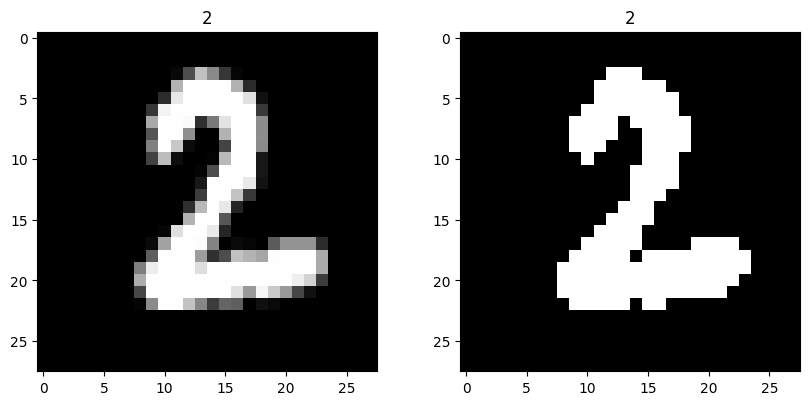

In [ ]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import random

''' This block takes the training and testing datasets as
    an argument and saves them to assigned locations.
    By iterating through every single data in the datasets
    it applies Otsu's threshold method to all of them and
    creates a copy of the dataset in the location.        '''


train_dataset_path = '/content/data/MNIST/train-dataset.pt'
test_dataset_path = '/content/data/MNIST/test-dataset.pt'

if not os.path.exists(train_dataset_path and test_dataset_path):
  train_data_otsu2 = [(torch.tensor(threshold_image(image[0], 0.2611499991255095)).unsqueeze(0).float(), label) for image, label in train_data]
  torch.save(train_data_otsu2, train_dataset_path)
  test_data_otsu2 = [(torch.tensor(threshold_image(image[0], 0.2611499991255095)).unsqueeze(0).float(), label) for image, label in test_data]
  torch.save(train_data_otsu2, test_dataset_path)
else:
    # If the dataset already exists, load it
    train_data_otsu2 = torch.load(train_dataset_path)
    test_data_otsu2 = torch.load(test_dataset_path)

random_number = random.randint(0,len(train_data_otsu2))
image, label = train_data[random_number]
image2, label2 = train_data_otsu2[random_number]
image2.shape, image.shape
print(f"This is normal{train_data[0][0].dtype}")
print(f"This is otsu{train_data_otsu2[0][0].dtype}")
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title(label)
plt.subplot(322); plt.imshow(image2.squeeze(),cmap='gray')
plt.title(label2)

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

combined_train_data = ConcatDataset([train_data_otsu2, train_data])
combined_test_data = ConcatDataset([test_data_otsu2, test_data])
BATCH_SIZE = 32
train_dataloader = DataLoader(combined_train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 3750 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
image6, label = test_data[0]
image6.shape

torch.Size([1, 28, 28])

In [ ]:
class_names = train_data.classes

In [ ]:
# Create a convolutional neural network
class DigitRecognizerMNISTV3(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_3 = DigitRecognizerMNISTV3(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_3

DigitRecognizerMNISTV3(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                             lr=0.01)

In [ ]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [ ]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_model_3 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_3,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_3,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_3 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_3,
                                           end=train_time_end_model_3,
                                           device=device)

NameError: name 'epochs' is not defined

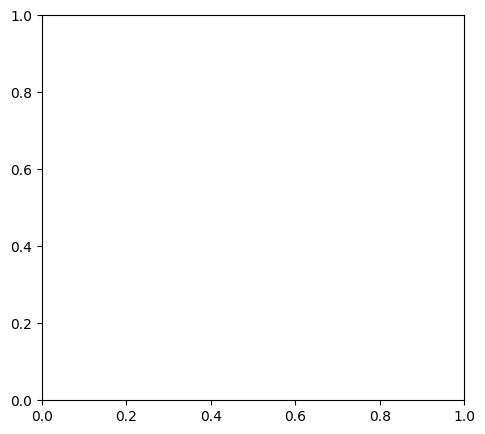

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_3_results = eval_model(model=model_3, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_func,
    device=device
)
model_3_results

{'model_name': 'DigitRecognizerMNISTV3',
 'model_loss': 2.3033552169799805,
 'model_acc': 10.313498402555911}

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_3.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_3.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_3.pth


In [ ]:
# Create a new instance of FashionMNISTModelV3 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
MODEL_SAVE_PATH = "models/03_pytorch_computer_vision_model_3.pth"
loaded_model_3 = DigitRecognizerMNISTV3(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_3 = loaded_model_3.to(device)

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_3_results = eval_model(
    model=loaded_model_3,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_func
)

loaded_model_3_results

NameError: name 'loss_fn' is not defined

Now we can start our process without training our model in the first place.

With using just -MODEL_SAVE_PATH = "models/03_pytorch_computer_vision_model_3.pth"-


Let's try to make a prediction based of a custom image provided from Google Images.

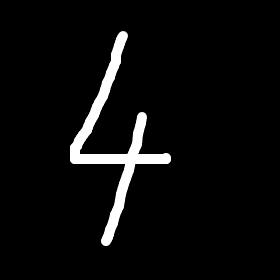

In [ ]:
from PIL import Image
prediction_image = Image.open('number-0_again_invert.jpg')
prediction_image



>> We need to transform our image to fit our model as a Tensor, size 28x28.







In [ ]:
from torchvision.transforms import ToTensor, Resize, Grayscale, Compose

transforms = Compose([
    Resize((28, 28)),
    ToTensor(),
])

transformed_prediction_image = transforms(prediction_image)
transformed_prediction_image.shape, transformed_prediction_image

(torch.Size([3, 28, 28]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

>> We can see that the shape is still unfit. We need to apply and change according to our model again

In [ ]:
transformed_shaped_prediction_image = transformed_prediction_image[0].unsqueeze(0)
transformed_shaped_prediction_image.shape

torch.Size([1, 28, 28])

>> We have fixed the shape. Now let's see if we have various pixel intensities for our image.

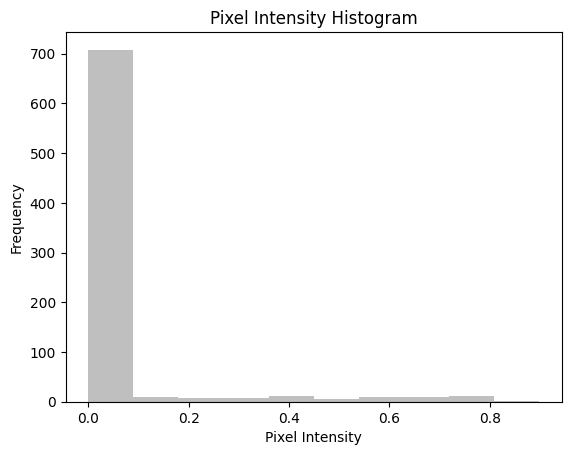

In [ ]:
flatten_image = nn.Flatten()
_prediction_image = flatten_image(transformed_shaped_prediction_image)

hist, bin_edges, number_of_x_values= plt.hist(_prediction_image, bins=10, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

>> We do have the pixel intensity levels accordingly. Let's plot our image to see how it looks in 28x28.

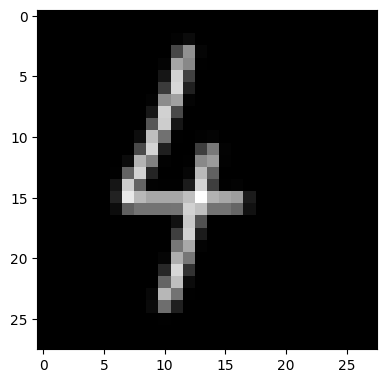

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(transformed_shaped_prediction_image.squeeze(),cmap='gray')

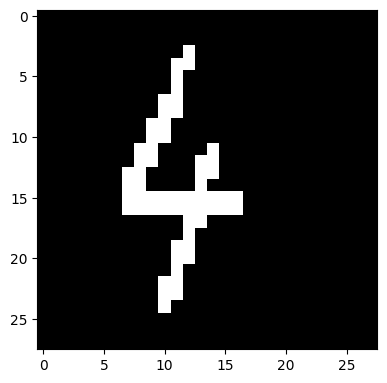

In [ ]:
_thresh = threshold_image(transformed_shaped_prediction_image, 0.261)
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(_thresh.squeeze(),cmap='gray')

```
loaded_model_3(img3)
```
>> If we were to use this first instance we will get the standard math error. We need to include batch size into our calculations ass wel!!

```
img5 = img3.unsqueeze(0)
loaded_model_3(img3)
```



In [ ]:
import torch
import torch.nn.functional as F

_thresh_tensor = torch.from_numpy(_thresh)
last_prediction = _thresh_tensor.unsqueeze(0).float()  # Convert to float
output = loaded_model_3(last_prediction)
_, predicted_class = torch.max(output, 1)
print('Predicted class:', predicted_class.item())
output

probabilities = F.softmax(output, dim=1)
predicted_class_probability = probabilities[0, predicted_class.item()].item()

print(f'Probability of predicted class:{predicted_class_probability*100:.6f}%')

Predicted class: 4
Probability of predicted class:99.953032%


>> We got the correct answer let's try it on a larger scale to push the difficulty on our model.

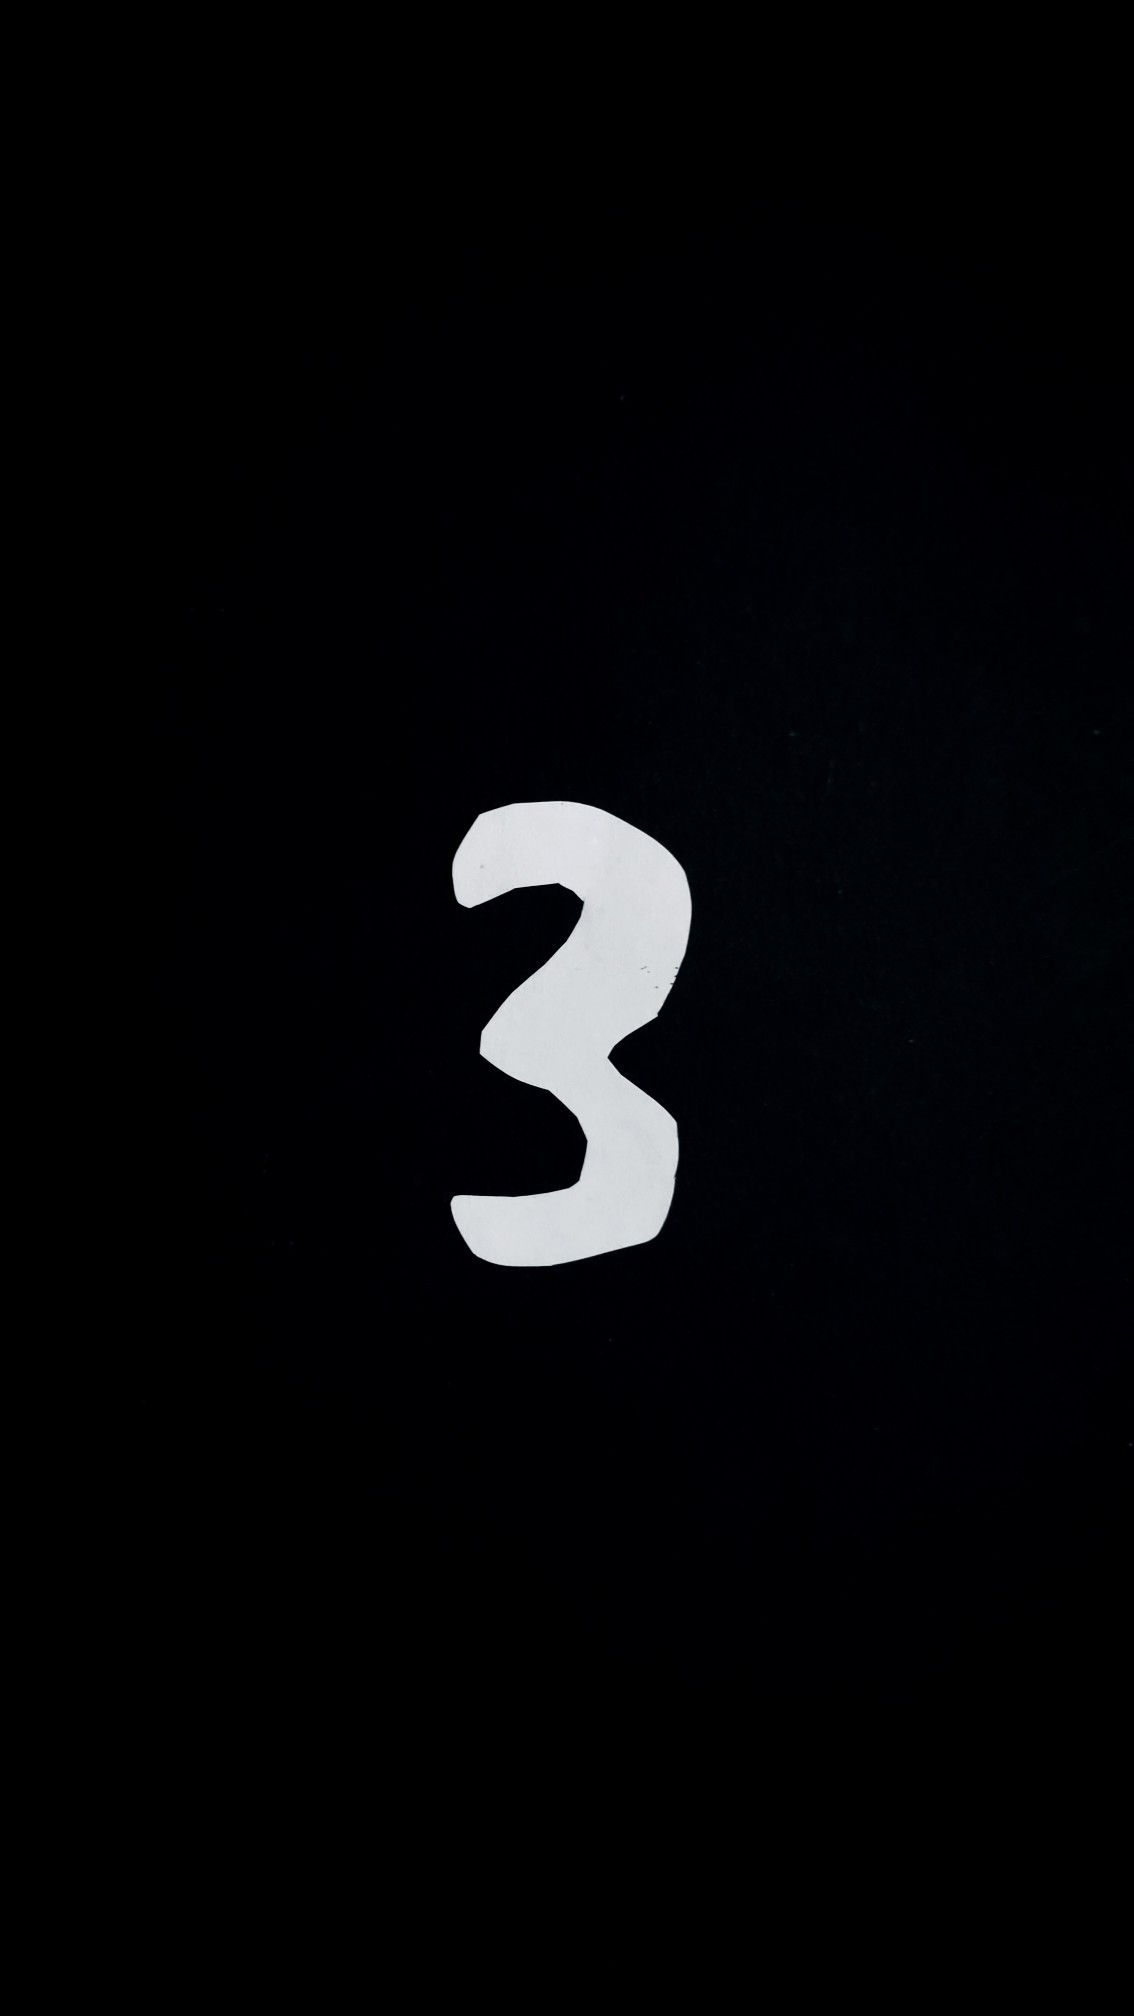

In [ ]:
from PIL import Image
prediction_image_2 = Image.open("number-3.jpg")
prediction_image_2

In [ ]:
from torchvision.transforms import ToTensor, Resize, Grayscale, Compose

transforms = Compose([
    Resize((28, 28)),
    ToTensor(),
])

transformed_prediction_image_2 = transforms(prediction_image_2)
transformed_prediction_image_2.shape, transformed_prediction_image_2

(torch.Size([3, 28, 28]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [ ]:
transformed_shaped_prediction_image_2 = transformed_prediction_image_2[0].unsqueeze(0)
transformed_shaped_prediction_image_2.shape

torch.Size([1, 28, 28])

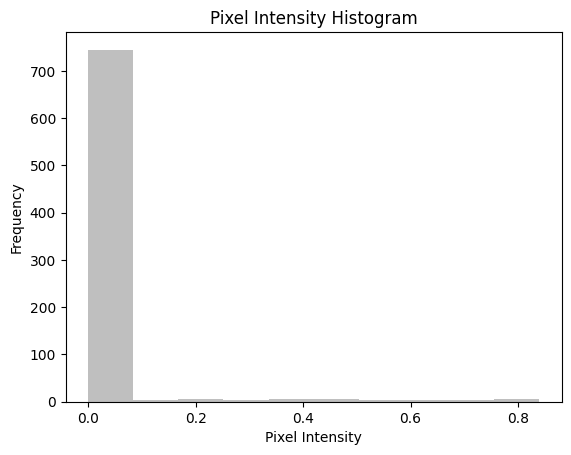

In [ ]:
flatten_image = nn.Flatten()
_prediction_image_2 = flatten_image(transformed_shaped_prediction_image_2)

hist, bin_edges, number_of_x_values= plt.hist(_prediction_image_2, bins=10, color='gray', alpha=0.5)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

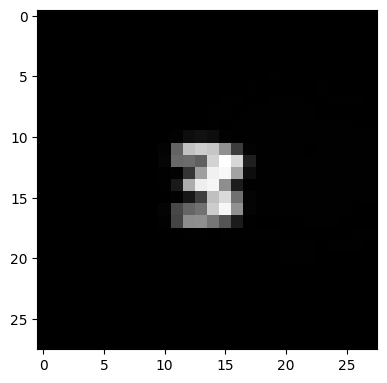

In [ ]:
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(transformed_shaped_prediction_image_2.squeeze(),cmap='gray')

In [ ]:
last_prediction_2 = transformed_shaped_prediction_image_2.unsqueeze(0)

output_2 = loaded_model_3(last_prediction_2)
_, predicted_class_2 = torch.max(output_2, 1)
print('Predicted class:', predicted_class_2.item())

Predicted class: 3


>> The answer is still correct so our model performs great so far!

>> Next versions are implemented in my [Github repository](https://github.com/haldonmez/canvas-input-website).